In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import gc
import sys
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random as rnd

from sklearn.model_selection import train_test_split


import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, LeakyReLU
from keras.models import Sequential, Model
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers, optimizers

from sklearn.preprocessing import MinMaxScaler

### **Loading data**:

Initializing access paths from google drive

In [3]:
home_path = '/content/drive/MyDrive/DMProj/'
file_path = home_path + "Grapevine_Leaves_Image_Dataset/"
Ak = file_path + "Ak"
Ala_Idris = file_path + "Ala_Idris"
Buzgulu = file_path + "Buzgulu"
Dimnit = file_path + "Dimnit"
Nazli = file_path + "Nazli"

main_df = pd.DataFrame()
main_df['images'] = os.listdir(Ak) + os.listdir(Ala_Idris) \
        + os.listdir(Buzgulu) + os.listdir(Dimnit) \
        + os.listdir(Nazli)

Counting Classes and initializing paths

In [4]:
classes = []
path = []
for image in main_df["images"]:
    spec = image.split(' ')[0]
    classes.append(spec)
    path.append(file_path+spec+'/'+image)

main_df["classes"] = classes
main_df["path"] = path

### Visualization

#### Pie chart:

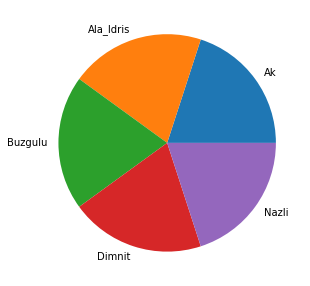

In [7]:
plt.figure(figsize=(5,5))
class_cnt = main_df.groupby(["classes"]).size().reset_index(name = "counts")
plt.pie(class_cnt["counts"], labels=class_cnt["classes"])
plt.show()

### **Sample images of each class**:

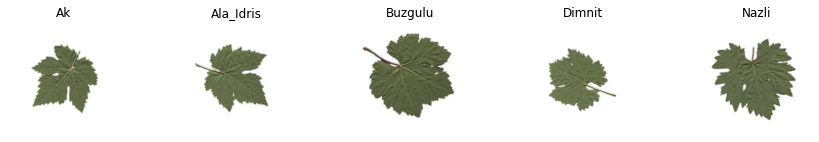

In [8]:
plt.figure(figsize = (15,12))
for j,i in enumerate(main_df.classes.unique()):
    plt.subplot(5,5,j+1)
    df = main_df[main_df["classes"] == i].reset_index(drop = True)
    image_path = df.loc[0,"path"]
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.title(i)
plt.show()

### Preprocessing

#### **Splitting data**:

In [5]:
label = main_df["classes"]
new_df =  main_df[["images", "path"]].copy()

X_train, X_test, y_train, y_test = train_test_split(new_df, label, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print("Train dataset size: ", X_train.shape)
print("Validation dataset size: ", X_val.shape)
print("Test dataset size: ", X_test.shape)

Train dataset size:  (320, 2)
Validation dataset size:  (80, 2)
Test dataset size:  (100, 2)


In [33]:
train_dataset = pd.concat([X_train, y_train], axis=1, join="inner")
# print(train_dataset.shape)
# print(X_train["path"][0])
valid_dataset = pd.concat([X_val, y_val], axis=1, join="inner")
test_dataset = pd.concat([X_test, y_test], axis=1, join="inner")
total_dataset = pd.concat([new_df, label], axis=1, join="inner")

#### **Data augmentation**:


*   Initializing the DataFrameIterators



In [14]:
class CombinedGen():
    def __init__(self, *gens):
        self.gens = gens

    def generate(self):
        while True:
            for g in self.gens:
                yield next(g)

    def __len__(self):
        return sum([len(g) for g in self.gens])

In [15]:
image_generator = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.15,
    brightness_range=[0.5,1.5],
    channel_shift_range=0.5,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input
) 

test_image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

image_size = (200, 200)
batch_size = 32
img_shape=(image_size[0], image_size[1], 3)

train_generator_aug = image_generator.flow_from_dataframe(
    train_dataset,
    x_col="path",
    y_col="classes",
    target_size=image_size, 
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

train_generator_orginal = test_image_generator.flow_from_dataframe(
    train_dataset,
    x_col="path",
    y_col="classes",
    target_size=image_size, 
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

train_generator = CombinedGen(train_generator_orginal, train_generator_aug)

valid_generator_aug = image_generator.flow_from_dataframe(
    valid_dataset,
    x_col="path",
    y_col="classes",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

valid_generator_original = test_image_generator.flow_from_dataframe(
    valid_dataset,
    x_col="path",
    y_col="classes",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

valid_generator = CombinedGen(valid_generator_original, valid_generator_aug)

test_generator = test_image_generator.flow_from_dataframe(
        test_dataset,
        x_col="path",
        y_col="classes",
        target_size=image_size, 
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
)

Found 320 validated image filenames belonging to 5 classes.
Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


Safty call back to save best parameters. In case ....

In [11]:
cb = tf.keras.callbacks.ModelCheckpoint(home_path + "save_weights_3.h5", save_best_only=True)
callbacks = [cb]

### Creating models

#### **EfficientNet B3**:

In [16]:
from tensorflow.keras.optimizers import Adam, Adamax

base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, \
        weights="imagenet",input_shape=img_shape, pooling='max') 
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.015),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x=Dropout(rate=0.4, seed=123)(x)       
output=Dense(5, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [19]:
history=model.fit(x=train_generator_orginal,  epochs=50, verbose=1,
    validation_data=valid_generator_original, validation_steps = None,  shuffle = True,
    initial_epoch=0, callbacks = callbacks)

Epoch 1/50
10/10 [==============================] - 50s 5s/step - loss: 3.4574 - accuracy: 0.9969 - val_loss: 3.4949 - val_accuracy: 0.9500
Epoch 2/50
10/10 [==============================] - 8s 762ms/step - loss: 3.3357 - accuracy: 1.0000 - val_loss: 3.4061 - val_accuracy: 0.9375
Epoch 3/50
10/10 [==============================] - 8s 782ms/step - loss: 3.2404 - accuracy: 0.9969 - val_loss: 3.3149 - val_accuracy: 0.9375
Epoch 4/50
10/10 [==============================] - 8s 771ms/step - loss: 3.1481 - accuracy: 1.0000 - val_loss: 3.2169 - val_accuracy: 0.9375
Epoch 5/50
10/10 [==============================] - 8s 789ms/step - loss: 3.0559 - accuracy: 1.0000 - val_loss: 3.1259 - val_accuracy: 0.9375
Epoch 6/50
10/10 [==============================] - 8s 770ms/step - loss: 2.9771 - accuracy: 0.9937 - val_loss: 3.0405 - val_accuracy: 0.9375
Epoch 7/50
10/10 [==============================] - 8s 765ms/step - loss: 2.8918 - accuracy: 0.9969 - val_loss: 2.9559 - val_accuracy: 0.9375
Epoch 8/

In [20]:
pred = model.evaluate(test_generator)

4/4 [==============================] - 38s 13s/step - loss: 0.9346 - accuracy: 0.9600


| epoch |learning rate | val accuracy | test accuracy |
| --- | --- | --- | ---|
| 50 | 0.001 | 96.25.0 | 96.0 |
| 40 | 0.0005 | 93.0 | 91.4 |
| 40 | 0.005 | 96.0 | 92 |

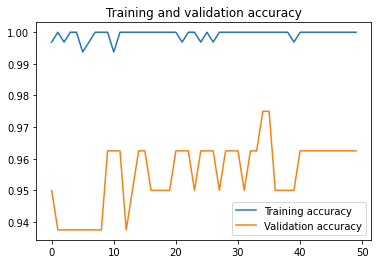

<Figure size 432x288 with 0 Axes>

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

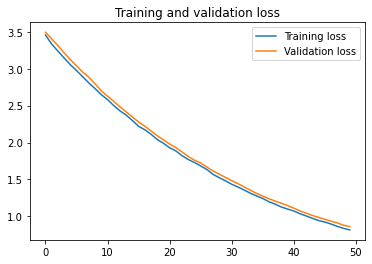

<Figure size 432x288 with 0 Axes>

In [113]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [24]:
model.save(home_path + "BestEffiNet(96%).h5")

#### **Autoencoder**:

In [56]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Reshape
# from tensorflow.keras.layers.advanced_activations import LeakyReLU

input_shape = (image_size[0], image_size[1], 3)
n_input = input_shape[0] * input_shape[1] * input_shape[2]
bottle_neck = 15

encoder = Sequential()
# encoder.add(Input(shape = input_shape, batch_size=batch_size))
encoder.add(layers.Rescaling(1./255, input_shape = input_shape))

encoder.add(layers.Conv2D(16, 3, padding='same', strides = 2, activation='relu'))
encoder.add(layers.MaxPooling2D())

encoder.add(layers.Conv2D(16, 3, padding='valid', strides = 2, activation='relu'))
encoder.add(layers.MaxPooling2D())

encoder.add(layers.Flatten())
encoder.add(layers.Dense(100, activation='relu'))

#bottle neck
encoder.add(Dense(bottle_neck, activation = "relu"))

encoder.compile(optimizer='adam',
              loss="mse",
              metrics=['accuracy'])

encoder.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2304)             

In [57]:
from keras.engine import sequential

decoder = Sequential()
decoder.add(layers.Input(shape=(bottle_neck)))

decoder.add(Dense(40000, activation="relu"))

decoder.add(Reshape((50, 50, 16)))
decoder.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
decoder.add(UpSampling2D((2, 2)))

decoder.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
decoder.add(UpSampling2D((2, 2)))



decoder.add(Conv2D(3, (3, 3), padding='same'))

decoder.add(layers.Rescaling(255))

decoder.add(Reshape(input_shape))

decoder.compile(optimizer='adam',
              loss="mse",
              metrics=['accuracy'])

decoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 40000)             640000    
                                                                 
 reshape_4 (Reshape)         (None, 50, 50, 16)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        9280      
                                                                 
 up_sampling2d_4 (UpSampling  (None, 100, 100, 64)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 16)      9232      
                                                                 
 up_sampling2d_5 (UpSampling  (None, 200, 200, 16)     0         
 2D)                                                  

In [58]:
autoencoder_input = Input(shape=input_shape)
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = Model(autoencoder_input, decoded_img, name="autoencoder")

autoencoder.compile(optimizer='adam',
              loss="mse",
              metrics=['accuracy'])

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 15)                234783    
                                                                 
 sequential_5 (Sequential)   (None, 200, 200, 3)       658947    
                                                                 
Total params: 893,730
Trainable params: 893,730
Non-trainable params: 0
_________________________________________________________________


In [142]:
autencoder_datagen = ImageDataGenerator(
    re
) 

autoencoder_train_generator = autencoder_datagen.flow_from_dataframe(
    total_dataset,
    x_col='path',
    y_col='classes',
    target_size=image_size, 
    batch_size=1,
    class_mode="categorical",
    shuffle=True,
)

arr = []
for i in range(len(autoencoder_train_generator)):
    arr.append(autoencoder_train_generator[i][0][0])

arr = np.array(arr)


Found 500 validated image filenames belonging to 5 classes.


In [62]:
autoencoder_history = autoencoder.fit(x=arr, y=arr, epochs=100, \
        verbose=1, shuffle=True)

Epoch 1/100
16/16 [==============================] - 2s 57ms/step - loss: 7839.4712 - accuracy: 0.3537
Epoch 2/100
16/16 [==============================] - 1s 53ms/step - loss: 2904.0835 - accuracy: 0.2921
Epoch 3/100
16/16 [==============================] - 1s 52ms/step - loss: 2520.6208 - accuracy: 0.6473
Epoch 4/100
16/16 [==============================] - 1s 52ms/step - loss: 2320.1675 - accuracy: 0.7348
Epoch 5/100
16/16 [==============================] - 1s 53ms/step - loss: 2033.2316 - accuracy: 0.7748
Epoch 6/100
16/16 [==============================] - 1s 53ms/step - loss: 1766.5945 - accuracy: 0.8207
Epoch 7/100
16/16 [==============================] - 1s 53ms/step - loss: 1659.9800 - accuracy: 0.8416
Epoch 8/100
16/16 [==============================] - 1s 52ms/step - loss: 1617.0283 - accuracy: 0.8524
Epoch 9/100
16/16 [==============================] - 1s 53ms/step - loss: 1584.5032 - accuracy: 0.8642
Epoch 10/100
16/16 [==============================] - 1s 53ms/step - loss

In [63]:
autoencoder.save(home_path+"autoencoder15(95.92%).h5")
encoder.save(home_path+"encoder15(95.92%).h5")

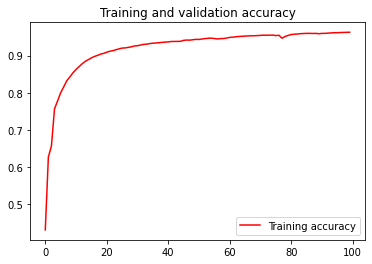

<Figure size 432x288 with 0 Axes>

In [44]:
autoencoder_acc = autoencoder_history.history['accuracy']

epochs = range(len(autoencoder_acc))

plt.plot(epochs, autoencoder_acc, 'r', label='Training accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

#### **Advanced model**:

In [64]:
from typing_extensions import Concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, Adamax


# adv_model_input = Input(shape=input_shape)
# encoded_img = encoder(autoencoder_input)



adv_base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False, \
        weights = "imagenet", input_shape = img_shape, pooling = 'max')
adv_base_model.trainable = True

encoded_img = encoder(adv_base_model.input)

x = adv_base_model.output
x = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001 )(x)

x = tf.keras.layers.concatenate([encoded_img, x])
x = Dense(250, kernel_regularizer = regularizers.l2(l = 0.015),
        activity_regularizer = regularizers.l1(0.005),
        bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x = Dropout(rate=0.4, seed=1)(x)
# print (x.shape)
adv_output = Dense(5, activation='softmax')(x)
adv_model = Model(inputs = adv_base_model.input, outputs = adv_output)
adv_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [65]:
adv_model_history=adv_model.fit(x=train_generator_orginal,  epochs=50, verbose=1,
        validation_data = valid_generator_original, validation_steps = None,  shuffle = True,
        initial_epoch=0, callbacks = callbacks)

Epoch 1/50
10/10 [==============================] - 22s 839ms/step - loss: 9.5089 - accuracy: 0.4281 - val_loss: 14.7574 - val_accuracy: 0.2500
Epoch 2/50
10/10 [==============================] - 6s 611ms/step - loss: 8.0952 - accuracy: 0.8219 - val_loss: 14.0232 - val_accuracy: 0.2625
Epoch 3/50
10/10 [==============================] - 6s 571ms/step - loss: 7.5691 - accuracy: 0.9250 - val_loss: 13.2845 - val_accuracy: 0.3000
Epoch 4/50
10/10 [==============================] - 6s 581ms/step - loss: 7.2156 - accuracy: 0.9531 - val_loss: 11.4237 - val_accuracy: 0.4000
Epoch 5/50
10/10 [==============================] - 6s 578ms/step - loss: 6.9198 - accuracy: 0.9781 - val_loss: 9.3735 - val_accuracy: 0.4375
Epoch 6/50
10/10 [==============================] - 6s 581ms/step - loss: 6.6309 - accuracy: 0.9719 - val_loss: 8.2238 - val_accuracy: 0.5500
Epoch 7/50
10/10 [==============================] - 6s 577ms/step - loss: 6.3535 - accuracy: 0.9750 - val_loss: 7.3431 - val_accuracy: 0.6625
E

In [66]:
pred = adv_model.evaluate(test_generator)

4/4 [==============================] - 1s 171ms/step - loss: 1.7338 - accuracy: 0.9100


In [68]:
adv_model.save(home_path + "AdvEffiNet91.h5")

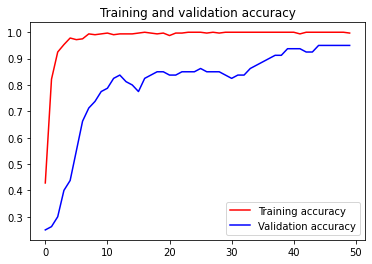

<Figure size 432x288 with 0 Axes>

In [69]:
adv_acc = adv_model_history.history['accuracy']
adv_val_acc = adv_model_history.history['val_accuracy']

epochs = range(len(adv_acc))

plt.plot(epochs, adv_acc, 'r', label='Training accuracy')
plt.plot(epochs, adv_val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

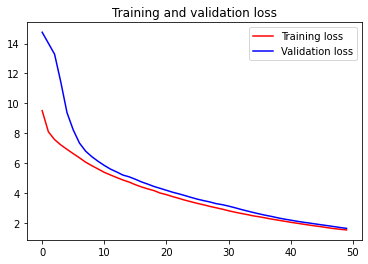

<Figure size 432x288 with 0 Axes>

In [70]:
adv_loss = adv_model_history.history['loss']
adv_val_loss = adv_model_history.history['val_loss']

epochs = range(len(adv_loss))

plt.plot(epochs, adv_loss, 'r', label='Training loss')
plt.plot(epochs, adv_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [84]:
adv_base_model2 = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False, \
        weights = "imagenet", input_shape = img_shape, pooling = 'max')
adv_base_model2.trainable = True

encoder = tf.keras.models.load_model(home_path + "encoder1.h5")
encoded_img = encoder(adv_base_model2.input)

x = adv_base_model2.output
x = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001 )(x)

x = Dense(150, kernel_regularizer = regularizers.l2(l = 0.015),
        activity_regularizer = regularizers.l1(0.005),
        bias_regularizer=regularizers.l1(0.005), activation='relu')(x)

x = tf.keras.layers.concatenate([encoded_img, x])
x = Dense(250, kernel_regularizer = regularizers.l2(l = 0.015),
        activity_regularizer = regularizers.l1(0.005),
        bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x = Dropout(rate=0.4, seed=1)(x)
# print (x.shape)
adv_output2 = Dense(5, activation='softmax')(x)
adv_model2 = Model(inputs = adv_base_model2.input, outputs = adv_output2)
adv_model2.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
adv_model2_history=adv_model2.fit(x=train_generator_orginal,  epochs=50, verbose=1,
        validation_data = valid_generator_original, validation_steps = None,  shuffle = True,
        initial_epoch=0, callbacks = callbacks)

Epoch 1/50
10/10 [==============================] - 23s 863ms/step - loss: 9.3119 - accuracy: 0.4187 - val_loss: 10.6262 - val_accuracy: 0.3625
Epoch 2/50
10/10 [==============================] - 6s 601ms/step - loss: 8.3275 - accuracy: 0.7625 - val_loss: 9.4629 - val_accuracy: 0.3500
Epoch 3/50
10/10 [==============================] - 6s 596ms/step - loss: 7.7691 - accuracy: 0.8969 - val_loss: 9.1545 - val_accuracy: 0.3125
Epoch 4/50
10/10 [==============================] - 6s 599ms/step - loss: 7.3089 - accuracy: 0.9688 - val_loss: 8.7107 - val_accuracy: 0.3125
Epoch 5/50
10/10 [==============================] - 6s 605ms/step - loss: 7.0067 - accuracy: 0.9750 - val_loss: 8.2346 - val_accuracy: 0.3250
Epoch 6/50
10/10 [==============================] - 7s 642ms/step - loss: 6.6906 - accuracy: 0.9906 - val_loss: 7.7697 - val_accuracy: 0.3750
Epoch 7/50
10/10 [==============================] - 6s 607ms/step - loss: 6.4166 - accuracy: 0.9906 - val_loss: 7.4859 - val_accuracy: 0.4000
Epoc

In [86]:
pred = adv_model2.evaluate(test_generator)

4/4 [==============================] - 1s 177ms/step - loss: 1.6369 - accuracy: 0.9000


In [87]:
adv_model2.save(home_path + "Adv2EffiNet90.h5")

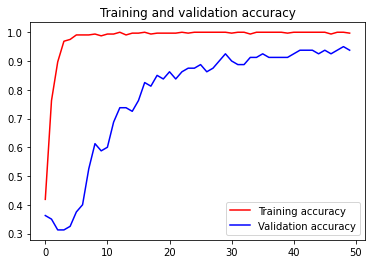

<Figure size 432x288 with 0 Axes>

In [88]:
adv2_acc = adv_model2_history.history['accuracy']
adv2_val_acc = adv_model2_history.history['val_accuracy']

epochs = range(len(adv2_acc))

plt.plot(epochs, adv2_acc, 'r', label='Training accuracy')
plt.plot(epochs, adv2_val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

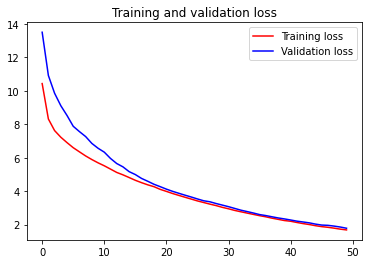

<Figure size 432x288 with 0 Axes>

In [80]:
adv2_loss = adv_model2_history.history['loss']
adv2_val_loss = adv_model2_history.history['val_loss']

epochs = range(len(adv_loss))

plt.plot(epochs, adv2_loss, 'r', label='Training loss')
plt.plot(epochs, adv2_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

#### **Confusion matrix**

In [108]:
plain_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
) 

plain_data = plain_datagen.flow_from_dataframe(
    total_dataset,
    x_col='path',
    y_col='classes',
    target_size=image_size, 
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
)

arr = []
for i in range(len(plain_data)):
    arr.append(plain_data[i][0][0])

arr = np.array(arr)

Found 500 validated image filenames belonging to 5 classes.


In [112]:
pred = model.predict(arr)
pred_class = np.argmax(pred, axis=-1)
labels = []

for l in label:
  labels.append(autoencoder_train_generator.class_indices[l])

print ("EfficientNet3:")
print (tf.math.confusion_matrix(labels = labels, predictions=pred_class).numpy())

EfficientNet3:
[[100   0   0   0   0]
 [  0  97   2   1   0]
 [  0   1  98   1   0]
 [  1   0   0  99   0]
 [  0   0   1   0  99]]


In [111]:
pred = adv_model2.predict(arr)
pred_class = np.argmax(pred, axis=-1)
labels = []

for l in label:
  labels.append(autoencoder_train_generator.class_indices[l])

print ("Advanced EfficientNet3:")
print (tf.math.confusion_matrix(labels = labels, predictions=pred_class).numpy())

Advanced EfficientNet3:
[[ 99   0   0   1   0]
 [  0  95   4   0   1]
 [  0   0 100   0   0]
 [  4   0   2  91   3]
 [  0   0   0   0 100]]


#### **Cross validation** 

In [ ]:
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(new_df, label, test_size=0.2, random_state=1)

kf = KFold(n_splits=2, shuffle = True)

results = []

for train_index, test_index in kf.split(new_df):
    # print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_val = new_df[train_index], new_df[test_index]
    y_train, y_val = label[train_index], label[test_index]

    valid_dataset = pd.concat([x_val, y_val], axis=1, join="inner")
    train_dataset = pd.concat([x_train, y_train], axis=1, join="inner")

    train_generator_original = test_image_generator.flow_from_dataframe(
        train_dataset,
        x_col="path",
        y_col="classes",
        target_size=image_size, 
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
    )

    valid_generator_original = test_image_generator.flow_from_dataframe(
        valid_dataset,
        x_col="path",
        y_col="classes",
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
    )

    model.fit(x=train_generator_original,  epochs=50, verbose=1,
        validation_data=valid_generator_original, validation_steps = None,  shuffle = True,
        initial_epoch=0, callbacks = callbacks)
    
    results.append(model.evaluate(test_generator))

print(results)
